In [ ]:
# Import the Images module from pillow
from PIL import Image
  
# Open the image by specifying the image path.
image_path = "/content/g0001.jpg"
image_file = Image.open(image_path)
  
# the default
image_file.save("image_name.jpg", quality=95)
  
# Changing the image resolution using quality parameter
# Example-1
image_file.save("image_name2.jpg", quality=25)
  
# Example-2
image_file.save("image_name3.jpg", quality=1)

In [ ]:
# Example-3
image_file.save("image_name4.jpg", quality=110)

In [ ]:
# Example-4
image_file.save("image_name5.jpg", quality=210)

In [3]:
# Import the Images module from pillow
from PIL import Image
  
# Open the image by specifying the image path.
image_path = "/content/g0001.jpg"
image_file = Image.open(image_path)
# the default
image_file.save("image_name.jpg", quality=10)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


#Creating dataset

In [ ]:
from scipy import ndimage
import numpy as np
import os
import cv2

outPath = "/content/gdrive/MyDrive/Glaucoma"
path = "/content/gdrive/MyDrive/Glaucoma_low"
for image in os.listdir(path):
    image.save("img.jpg", quality=10)
    img_path = "/content/img.jpg"
    fullpath = os.path.join(outPath, img_path)

In [5]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

In [6]:
face_images = glob.glob('/content/gdrive/MyDrive/Non-Glaucoma/*.jpg') #returns path of images
print(len(face_images)) #contains images

251


In [10]:
from tqdm import tqdm
from multiprocessing import Pool
progress = tqdm(total= len(face_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img
p = Pool(10)
img_array = p.map(read, face_images)

 11%|█         | 28/251 [00:38<04:49,  1.30s/it]

In [12]:
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)
  print(len(img_array))

251


In [13]:
all_images = np.array(img_array)#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [16]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)  
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)  
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA) 
  return low_res_image

In [19]:
train_x_px = []
for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)
train_x_px = np.array(train_x_px)   #Distorted images# get low resolution images for the validation set
val_x_px = []
for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)
val_x_px = np.array(val_x_px)     #Distorted images

In [24]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [25]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [26]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [27]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=500,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/500
7/7 [==============================] - 60s 8s/step - loss: 0.0100 - accuracy: 0.9524 - val_loss: 0.0023 - val_accuracy: 0.9592
Epoch 2/500


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


7/7 [==============================] - 58s 8s/step - loss: 0.0015 - accuracy: 0.9045 - val_loss: 0.0018 - val_accuracy: 0.8312
Epoch 3/500
7/7 [==============================] - 58s 8s/step - loss: 0.0012 - accuracy: 0.8228 - val_loss: 0.0011 - val_accuracy: 0.8079
Epoch 4/500
7/7 [==============================] - 58s 8s/step - loss: 8.8661e-04 - accuracy: 0.8189 - val_loss: 8.8323e-04 - val_accuracy: 0.8699
Epoch 5/500
7/7 [==============================] - 58s 8s/step - loss: 8.0529e-04 - accuracy: 0.9181 - val_loss: 8.2988e-04 - val_accuracy: 0.9273
Epoch 6/500
7/7 [==============================] - 58s 8s/step - loss: 7.2901e-04 - accuracy: 0.9554 - val_loss: 7.6271e-04 - val_accuracy: 0.9448
Epoch 7/500
7/7 [==============================] - 58s 8s/step - loss: 6.7675e-04 - accuracy: 0.9659 - val_loss: 7.0836e-04 - val_accuracy: 0.9590
Epoch 8/500
7/7 [==============================] - 58s 8s/step - loss: 6.3967e-04 - accuracy: 0.9697 - val_loss: 6.8785e-04 - val_accuracy: 0.9612

In [28]:
results = autoencoder.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results)

2/2 [==============================] - 4s 1s/step - loss: 3.6053e-04 - accuracy: 0.9823
val_loss, val_accuracy [0.00036052503855898976, 0.9823315143585205]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


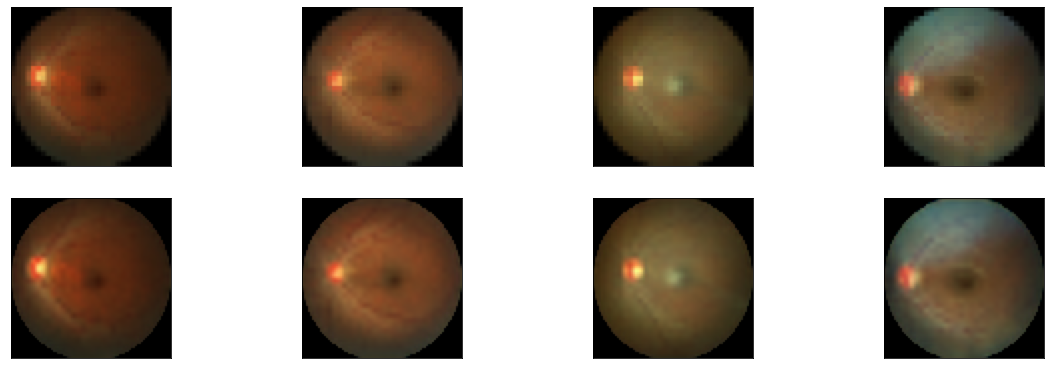

In [30]:
predictions = autoencoder.predict(val_x_px)
n = 4
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)  
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()